In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr

In [3]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist', 'Copy of Mnist_result.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist/Copy of Mnist_result.csv


In [4]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [5]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"conv1x1FLOPS": 0.012544, "conv1x1_3x3FLOPS": 0.909, "conv1x1_5x5FLOPS": 2.515, "totalFLOPS": 13.274}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [6]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['conv1x1', 'conv1x1_3x3', 'conv1x1_5x5']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','conv1x1',	'conv1x1_3x3',	'conv1x1_5x5'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [7]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_deeplift = calculate_normalized_variance(normalized_final_df, 'deeplift', flops_dict)
combined_avg_norm_var_acc_integrated_gradients = calculate_normalized_variance(normalized_final_df, 'integrated_gradients', flops_dict)

In [8]:
combined_avg_norm_var_acc_deeplift.to_csv(save_folder+"/mnist dl.csv")
combined_avg_norm_var_acc_deeplift=pd.read_csv(save_folder+"/mnist dl.csv")

In [9]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_3_accuracy_cols = [ 'test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_deeplift = filter_by_accuracy(combined_avg_norm_var_acc_deeplift)
filtered_integrated_gradients = filter_by_accuracy(combined_avg_norm_var_acc_integrated_gradients)

# Display the first few rows of the filtered dataframes
filtered_deeplift


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,norm_var_norm_conv1x1,norm_var_norm_conv1x1_3x3,norm_var_norm_conv1x1_5x5,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.192640,0.272455,0.534904,0.009546,0.089712,0.053723,0.050993,92.026444,93.465333,0.012544,0.909,2.515,13.274,93.465333
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.178649,0.302862,0.518489,0.005385,0.075824,0.050833,0.044014,90.999444,93.716000,0.012544,0.909,2.515,13.274,93.716000
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.208813,0.302602,0.488585,0.006949,0.058493,0.047347,0.037596,89.626889,93.467333,0.012544,0.909,2.515,13.274,93.467333
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.179482,0.275672,0.544846,0.006976,0.072898,0.046249,0.042041,92.097667,95.591333,0.012544,0.909,2.515,13.274,95.591333
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.167229,0.296077,0.536694,0.010879,0.070183,0.049309,0.043457,91.358111,95.528000,0.012544,0.909,2.515,13.274,95.528000
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.191870,0.295150,0.512980,0.010333,0.068789,0.052624,0.043915,90.031667,94.729333,0.012544,0.909,2.515,13.274,94.729333
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.309245,0.271473,0.419282,0.020408,0.108815,0.085446,0.071557,91.618444,92.663333,0.012544,0.909,2.515,13.274,92.663333
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.225480,0.307523,0.466997,0.010282,0.100081,0.079156,0.063173,90.940000,93.552667,0.012544,0.909,2.515,13.274,93.552667
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.247046,0.334986,0.417968,0.013166,0.078508,0.077052,0.056242,89.600444,93.302667,0.012544,0.909,2.515,13.274,93.302667
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.298896,0.264080,0.437023,0.015777,0.103294,0.074410,0.064494,91.691222,95.094000,0.012544,0.909,2.515,13.274,95.094000


# Graph

In [10]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [11]:
filtered_deeplift.to_csv(save_folder+"/mnsit dl ave var.csv")

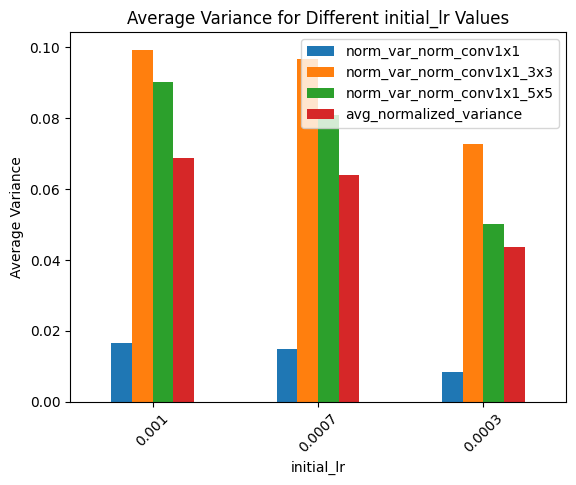

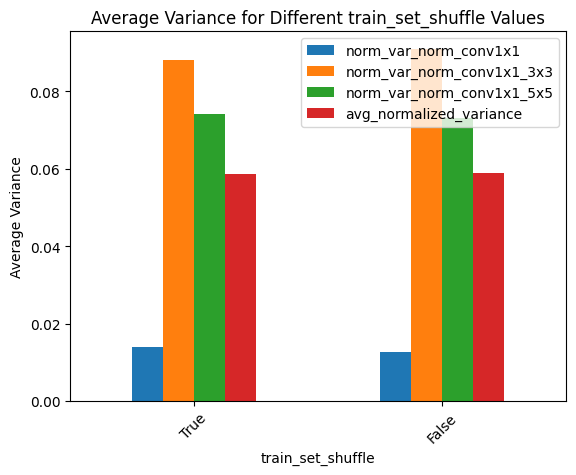

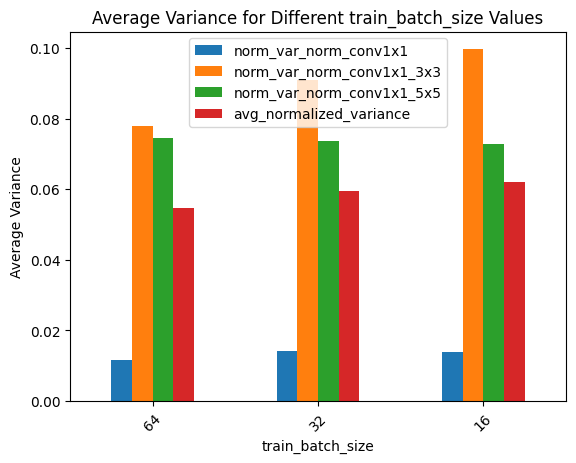

In [12]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_deeplift, hyperparam, variables)

# T test

In [13]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [14]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 1.8083778768593548 P-value: 0.10066826021372306


In [15]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 11.19245678721984 P-value: 5.609221378557498e-07


In [16]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 7.284827682083922 P-value: 2.6479447768286836e-05


train_set_shuffle

In [17]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.036526652822744074 P-value: 0.9713142711787122


train_batch_size

In [18]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.6979940403532592 P-value: 0.5010883878973844


In [19]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.0498016239649592 P-value: 0.31851772564581987


In [20]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.34433328553584786 P-value: 0.7377269630688541


# Paired T test

In [37]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [21]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [22]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [23]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [39]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0651296013590605 0.0609650658665182
0.0704191735828714 0.0675972427629788
0.0699402897572888 0.0644939071942761
0.0644593002956799 0.0562419635299799
0.0685874322154137 0.0631731219710234
0.0732368695575013 0.071556530688193
T-statistic: 4.935271556186091 One-sided P-value: 0.0021698877617204607


In [41]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0609650658665182 0.0439153817678163
0.0675972427629788 0.0434569180527542
0.0644939071942761 0.0420409604839107
0.0562419635299799 0.0375963020457745
0.0631731219710234 0.0440136886472314
0.071556530688193 0.0509933280222311
T-statistic: 19.08830358156366 One-sided P-value: 3.6370614276078866e-06


In [42]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0651296013590605 0.0439153817678163
0.0704191735828714 0.0434569180527542
0.0699402897572888 0.0420409604839107
0.0644593002956799 0.0375963020457745
0.0685874322154137 0.0440136886472314
0.0732368695575013 0.0509933280222311
T-statistic: 22.226943150261224 One-sided P-value: 1.7119945552755107e-06


train_set_shuffle

In [53]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0651296013590605 0.0644593002956799
0.0704191735828714 0.0685874322154137
0.0699402897572888 0.0732368695575013
0.0609650658665182 0.0562419635299799
0.0675972427629788 0.0631731219710234
0.0644939071942761 0.071556530688193
0.0439153817678163 0.0375963020457745
0.0434569180527542 0.0440136886472314
0.0420409604839107 0.0509933280222311
T-statistic: -0.11904775965614182 One-sided P-value: 0.5459136772874977


train_batch_size

In [50]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0704191735828714 0.0651296013590605
0.0685874322154137 0.0644593002956799
0.0675972427629788 0.0609650658665182
0.0631731219710234 0.0562419635299799
0.0434569180527542 0.0439153817678163
0.0440136886472314 0.0375963020457745
T-statistic: 4.238283142188888 One-sided P-value: 0.0040915234834818515


In [51]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0699402897572888 0.0704191735828714
0.0732368695575013 0.0685874322154137
0.0644939071942761 0.0675972427629788
0.071556530688193 0.0631731219710234
0.0420409604839107 0.0434569180527542
0.0509933280222311 0.0440136886472314
T-statistic: 1.2786168332529841 One-sided P-value: 0.12858152941423528


In [52]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0699402897572888 0.0651296013590605
0.0732368695575013 0.0644593002956799
0.0644939071942761 0.0609650658665182
0.071556530688193 0.0562419635299799
0.0420409604839107 0.0439153817678163
0.0509933280222311 0.0375963020457745
T-statistic: 2.7809719980249605 One-sided P-value: 0.019428690750673733


#layer feature attribution rank frequency comparison

In [31]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'deeplift']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-9-fd01ca0d0368>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,91.071667,95.25,deeplift,0,0.012544,0.909,2.515,13.274,0.287962,0.114105,0.597933,95.25
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,90.523333,95.08,deeplift,1,0.012544,0.909,2.515,13.274,0.167421,0.320473,0.512106,95.08
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,90.333333,95.71,deeplift,2,0.012544,0.909,2.515,13.274,0.203962,0.305839,0.490199,95.71
6,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,90.601667,95.54,deeplift,3,0.012544,0.909,2.515,13.274,0.221026,0.453410,0.325565,95.54
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,90.538333,94.27,deeplift,4,0.012544,0.909,2.515,13.274,0.251279,0.479094,0.269627,94.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,92.723333,93.65,deeplift,10,0.012544,0.909,2.515,13.274,0.174846,0.041287,0.783866,93.65
532,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,92.173333,93.25,deeplift,11,0.012544,0.909,2.515,13.274,0.209309,0.239782,0.550909,93.25
534,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,91.465000,93.49,deeplift,12,0.012544,0.909,2.515,13.274,0.155067,0.165786,0.679147,93.49
536,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,91.918333,93.77,deeplift,13,0.012544,0.909,2.515,13.274,0.185317,0.320043,0.494640,93.77


In [32]:
# Select the columns of interest
cols_of_interest = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-32-2b13f1656abd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


213    95
123    78
132    43
231    38
312    11
321     5
Name: rank_combination, dtype: int64